The generated sketches look nothing like hand drawn sketches, which are high contrast black lines with no shading. They also still include shadows and many have some background colour.

Need to do some work to prepare trhe sketch dataset closer to the target dataset.

U2-NET can remove much of the backgound and shadows.

HED instead of DexiNed may be better for simpler edge detection.

May need to do some bulk hand tuning of images to improve dataset.

Using a pretrained U2Net to remove backgrounds

https://github.com/shreyas-bk/U-2-Net/blob/master/u2net_test.py

https://colab.research.google.com/github/shreyas-bk/U-2-Net-Demo/blob/master/DEMOS/U_2_Netp_Demonstration_Colab.ipynb#scrollTo=eWxv7eDJiq5b

Uses U2NETP # small version u2net 4.7 MB

The snpachat filter blog poerforms HED then Canny edge detection ion the output of HED.

In [1]:
from IPython import get_ipython
get_ipython().run_line_magic('reload_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')

In [45]:
import pathlib
import os
import zipfile
import shutil
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image as Img
import cv2
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from skimage import feature
import skimage

from src.DexiNed_TF2.run_model import run_DexiNed
from src.config import get_dexined_inference_args

PATH = pathlib.Path.cwd()
DATA_DIR = PATH.parent / 'data'
U2_NET_DIR = DATA_DIR / "interim" / "U-2-Net output"
IMAGES_DIR = DATA_DIR / 'raw' / 'data-224'

# Unzip U2Net Outputs

In [12]:
# # in python 3.8, shutil.move will not accept pathlike objects
# zip_path = (DATA_DIR / "interim" / "results.zip").__str__()
# target_dir = (DATA_DIR / "interim" / "U-2-Net output").__str__()

# # make a folder to put the files
# if not os.path.exists(target_dir):
#     os.mkdir(target_dir)

# unzip the folder
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(target_dir)

# move the files to the right directory
# file_names = os.listdir(target_dir+"/content/U-2-Net/results")
# for file_name in file_names:
#     shutil.move(os.path.join(target_dir+"/content/U-2-Net/results", file_name), target_dir)

# remove the old directory
# os.removedirs(target_dir+"/content/U-2-Net/results")

# Explore U2Net Outputs

https://github.com/shreyas-bk/U-2-Net

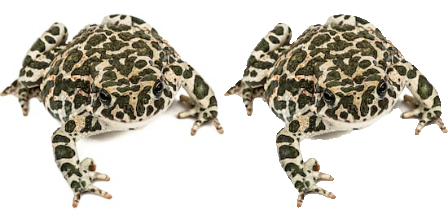

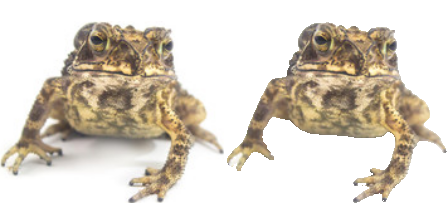

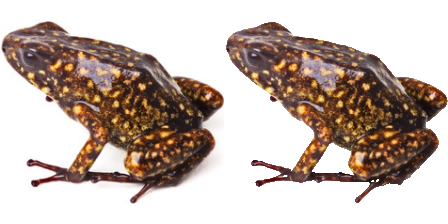

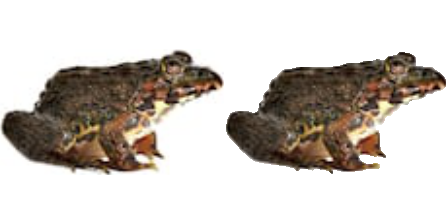

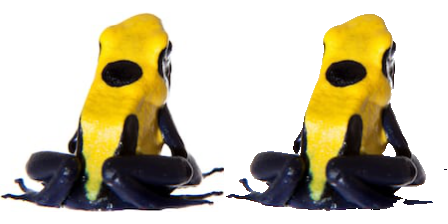

In [72]:
names = [name[:-4] for name in os.listdir(U2_NET_DIR)]
names = random.sample(names, 5)

THRESHOLD = 0.8
RESCALE = 255

for i, name in enumerate(names):

    # BACKGROUND REMOVAL
    if name == '.ipynb_checkpo':
        continue

    # load mask
    output = load_img(U2_NET_DIR / f"{name}.png")
    out_img = img_to_array(output)
    out_img /= RESCALE

    # convert mask to binary (224, 224, 3)
    out_img[out_img > THRESHOLD] = 1
    out_img[out_img <= THRESHOLD] = 0

    # convert to RGBA
    shape = out_img.shape
    # Convert to RGBA
    ## prepare layer of ones - full opacity
    a_layer_init = np.ones(shape=(shape[0], shape[1], 1))
    ## mask is RGB, we only need one channel
    mul_layer = out_img[...,-1:]
    ## mul_layer is 0 for background and 1 for frog
    ## multiply by array of ones to get alpha values for RGBA
    a_layer = mul_layer*a_layer_init
    ## combine RGB+A
    rgba_out = np.append(out_img,a_layer,axis=2)

    # load full image
    input = load_img(IMAGES_DIR / f"{name}.png")
    inp_img = img_to_array(input)
    inp_img /= RESCALE

    # image with removed background
    a_layer = np.ones(shape=(shape[0], shape[1], 1))
    rgba_inp = np.append(inp_img, a_layer,axis=2)
    rem_back = (rgba_inp*rgba_out)
    rem_back_scaled = rem_back*RESCALE
    
    # Output results

    inp_img*=RESCALE
    inp_img = np.append(inp_img,RESCALE*a_layer,axis=2)
    result = np.concatenate((inp_img,rem_back_scaled),axis=1)
    result_img = Img.fromarray(result.astype('uint8'), 'RGBA')
    display(result_img)


# Creating Model Inputs

Use raw image and U2Net output to create a "sketch".

## DexiNed inference from a Notebook

In [25]:
from src.DexiNed_TF2.run_model import run_DexiNed
from src.config import get_dexined_inference_args

def run_dexined(args):
    """Copied from main.py"""
    model = run_DexiNed(args=args)
    if args.model_state=='train':
        model.train()
    elif args.model_state =='test':
        model.test()
    else:
        raise NotImplementedError('Sorry you just can test or train the model, please set in '
                                  'args.model_state=')

# get dexined args
dexined_args = get_dexined_inference_args()

# get a few UNET2 examples to test
# put in a folder

# update for this specific case - file paths should be strings
## a few examples in a folder to test
dexined_args.update(dict(
    test_dir=DATA_DIR/'examples'/"U-2-Net sample",
    output_dir=DATA_DIR/"examples"/"U-2-Net sample ouput",
    checkpoint_dir=PATH.parent/"src"/"DexiNed_TF2",
    checkpoint="DexiNed23_model.h5",
    test_bs=1,
))


## test on a small sample
run_dexined(dexined_args)

# try out canny too and check this gives good results
# run everything

# train some models!



saved: c:\Users\ylene\Documents\Work\Projects\sketch2frog\sketch2frog\data\examples\U-2-Net sample ouput\DexiNed-BIPED2CLASSIC\h5\frog-1.h5 (8, 224, 224, 1)
saved: c:\Users\ylene\Documents\Work\Projects\sketch2frog\sketch2frog\data\examples\U-2-Net sample ouput\DexiNed-BIPED2CLASSIC\h5\frog-10.h5 (8, 224, 224, 1)
saved: c:\Users\ylene\Documents\Work\Projects\sketch2frog\sketch2frog\data\examples\U-2-Net sample ouput\DexiNed-BIPED2CLASSIC\h5\frog-11.h5 (8, 224, 224, 1)
saved: c:\Users\ylene\Documents\Work\Projects\sketch2frog\sketch2frog\data\examples\U-2-Net sample ouput\DexiNed-BIPED2CLASSIC\h5\frog-12.h5 (8, 224, 224, 1)
saved: c:\Users\ylene\Documents\Work\Projects\sketch2frog\sketch2frog\data\examples\U-2-Net sample ouput\DexiNed-BIPED2CLASSIC\h5\frog-13.h5 (8, 224, 224, 1)
saved: c:\Users\ylene\Documents\Work\Projects\sketch2frog\sketch2frog\data\examples\U-2-Net sample ouput\DexiNed-BIPED2CLASSIC\h5\frog-14.h5 (8, 224, 224, 1)
saved: c:\Users\ylene\Documents\Work\Projects\sketch2

## Exploring DexiNed Outputs

Compare:<br>
Input image x, Dexined(x), UNet(x), Dexined(Unet(x)), Canny(dexined(unet(x)))

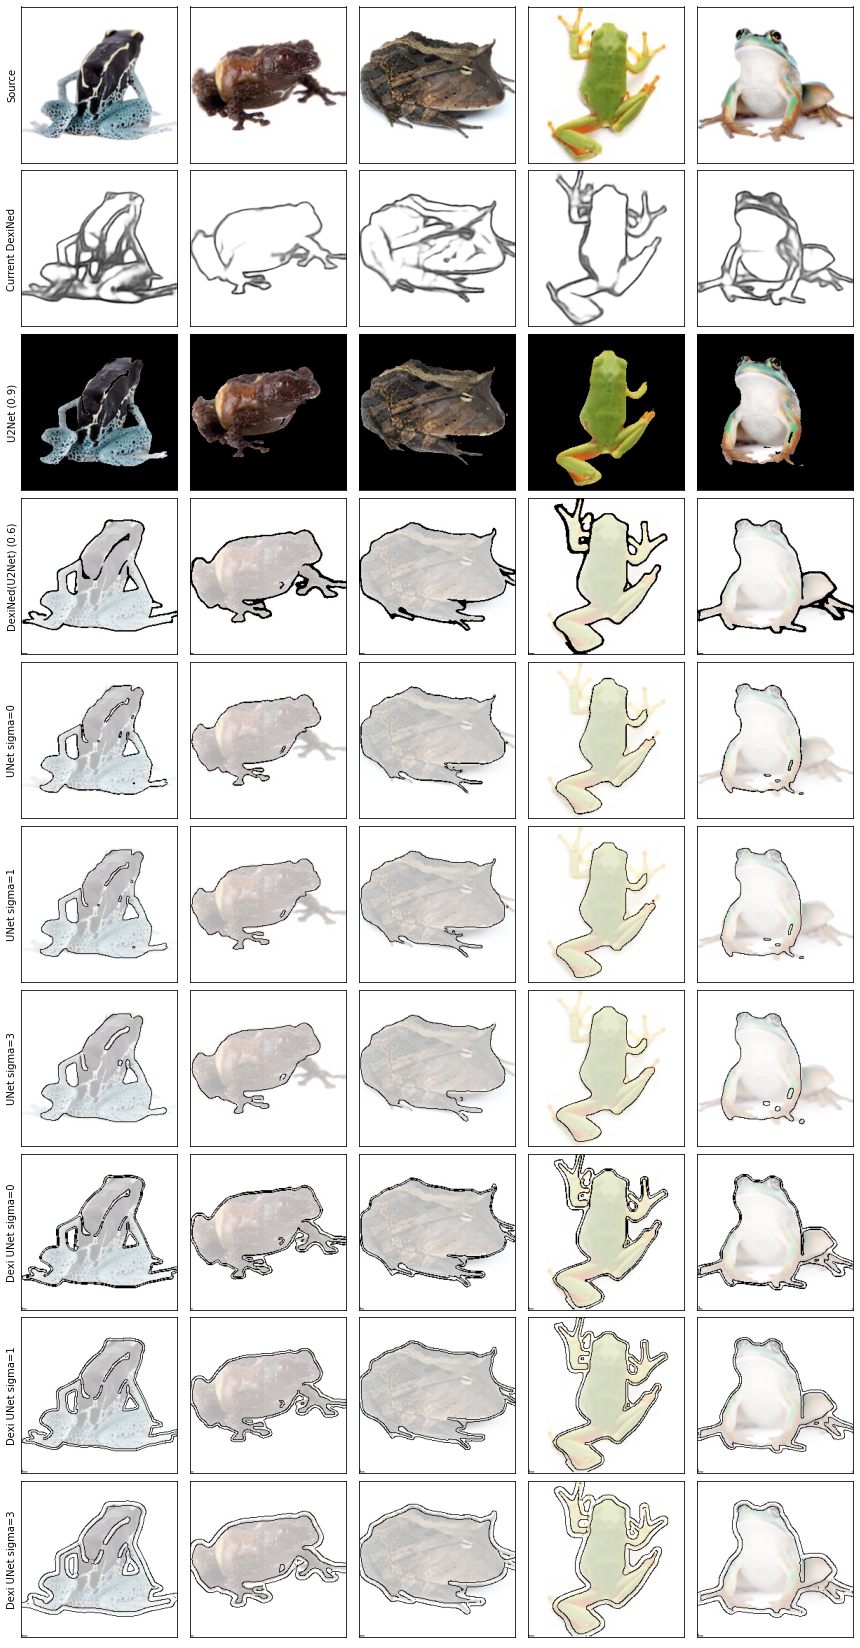

In [233]:
def print_edge_detection_examples(n=3, sigmas=[1,3], size=2, unet_threshold=0.7, dexi_unet_threshold=0.7, canny_kw=None):
    """
    Prints many approaches to creating sketches from the source images
    """
    
    canny_kw = {} if canny_kw is None else canny_kw
    
    # source, dexined, bg removed unet overlay (black), dexined(unet) + canny(dexined(unet))
    rows = 4 + len(sigmas)*2
    
    # prepare figure
    fig, axs = plt.subplots(rows, n, figsize=(size*n, size*rows))
    
    # get frog image names - only look in sample
    U2NET_output = DATA_DIR / 'examples' / 'U-2-Net sample'
    names = random.sample(list(U2NET_output.glob('*.png')), n)
    
    # each column is a new example
    for col, unet_fpath in enumerate(names):
        
        # get source(x)
        src_fpath = DATA_DIR / 'raw' / 'data-224' / unet_fpath.name
        
        # get dexined(x)
        dexi_fpath = DATA_DIR / 'interim' / 'DexiNed-fuse' / unet_fpath.name
        
        # get dexined(unet(x)) path
        dexi_unet_fpath = DATA_DIR / 'examples' \
            / 'U-2-Net sample ouput'  / 'DexiNed-BIPED2CLASSIC' \
            / 'fuse' / unet_fpath.name
            
        ########  source and current dexined  ########
        src_image = plt.imread(src_fpath)
        axs[0,col].imshow(src_image, cmap='gray')
        
        dexi_mask = plt.imread(dexi_fpath)
        axs[1,col].imshow(dexi_mask, cmap='gray') # current "sketch"

        ########  unet  ########
        unet_mask = plt.imread(unet_fpath)[:,:,0]

        # make mask binary
        unet_mask[unet_mask >  unet_threshold] = 1
        unet_mask[unet_mask <= unet_threshold] = 0

        # initialise masked image
        unet_masked = src_image.copy()
        # where the mask is zero, set the masked image's rgb values to 0
        unet_masked[:,:,:3] = np.where(unet_mask[:,:,np.newaxis]==0, np.zeros_like(unet_masked[:,:,:3]), unet_masked[:,:,:3])
        # set the opacity alpha to full (1) everywhere
        unet_masked[:,:,-1] = np.ones_like(unet_mask)
        axs[2,col].imshow(unet_masked)

        ########  dexi_unet  ########
        dexi_unet_mask = plt.imread(dexi_unet_fpath)

        # make mask binary
        dexi_unet_mask[dexi_unet_mask >  dexi_unet_threshold] = 1
        dexi_unet_mask[dexi_unet_mask <= dexi_unet_threshold] = 0

        # initialise masked image
        dexi_unet_masked = src_image.copy()
        # where the mask is zero, set the masked image's rgb values to 0
        dexi_unet_masked[:,:,:3] = np.where(dexi_unet_mask[:,:,np.newaxis]==0, np.zeros_like(dexi_unet_masked[:,:,:3]), dexi_unet_masked[:,:,:3])
        # set the opacity alpha to full (1) everywhere
        dexi_unet_masked[:,:,-1] = np.ones_like(dexi_unet_mask)

        axs[3,col].imshow(dexi_unet_mask, cmap='gray')
        axs[3,col].imshow(dexi_unet_masked, cmap='gray', alpha=0.3)

           
        ########  canny unet  ########
        canny_unet_edges = [skimage.feature.canny(unet_mask, sigma=sigma, **canny_kw).astype(int) for sigma in sigmas]

        for i, edges in enumerate(canny_unet_edges):
            # initialise masked image
            canny_unet_masked = src_image.copy()
            # where the mask is zero, set the masked image's rgb values to 0
            canny_unet_masked[:,:,:3] = np.where(
                edges[:,:,np.newaxis]==1, np.zeros_like(canny_unet_masked[:,:,:3]), canny_unet_masked[:,:,:3])
            # set the opacity alpha to full (1) everywhere
            canny_unet_masked[:,:,-1] = np.ones_like(edges)

            axs[i+4,col].imshow(edges, cmap='gray_r')
            axs[i+4,col].imshow(canny_unet_masked, cmap='gray', alpha=0.3)
            
        ########  canny dexi_unet  ########
        canny_dexi_unet_edges = [skimage.feature.canny(dexi_unet_mask, sigma=sigma, **canny_kw).astype(int) for sigma in sigmas]

        for i, edges in enumerate(canny_dexi_unet_edges):
            # initialise masked image
            canny_dexi_unet_masked = src_image.copy()
            # where the mask is zero, set the masked image's rgb values to 0
            canny_dexi_unet_masked[:,:,:3] = np.where(
                edges[:,:,np.newaxis]==1, np.zeros_like(canny_dexi_unet_masked[:,:,:3]), canny_dexi_unet_masked[:,:,:3])
            # set the opacity alpha to full (1) everywhere
            canny_dexi_unet_masked[:,:,-1] = np.ones_like(edges)

            axs[i+4+len(sigmas),col].imshow(edges, cmap='gray_r')
            axs[i+4+len(sigmas),col].imshow(canny_dexi_unet_masked, cmap='gray', alpha=0.3)

    for ax in matplotlib.cbook.flatten(axs):
        ax.set(xticks=[], yticks=[])
        
    # set titles
    axs[0,0].set_ylabel('Source')
    axs[1,0].set_ylabel('Current DexiNed')
    axs[2,0].set_ylabel(f'U2Net ({unet_threshold})')
    axs[3,0].set_ylabel(f'DexiNed(U2Net) ({dexi_unet_threshold})')
    for i, sigma in enumerate(sigmas):
        axs[i+4,0].set_ylabel(f'UNet sigma={sigma}')
    for i, sigma in enumerate(sigmas):
        axs[i+4+len(sigmas),0].set_ylabel(f'Dexi UNet sigma={sigma}')

    fig.patch.set_facecolor('white')      
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()
    plt.close()
     
print_edge_detection_examples(n=5, sigmas=[0,1,3], size=3, unet_threshold=0.9, dexi_unet_threshold=0.6)

From multiple rune the best results come from the following process:
1. Get source image
2. Pass through U2 Net model
3. Pass this through DexiNed
4. Convert to binary b&w with threshold 0.6

## Run DexiNed on all U2Net Outputs

In [ ]:
# get dexined args
dexined_args = get_dexined_inference_args()

# update for this specific case - file paths should be strings
## a few examples in a folder to test
dexined_args.update(dict(
    test_dir=DATA_DIR/'interim'/"U-2-Net output",
    output_dir=DATA_DIR/"interim"/"DexiNed(U-2-Net ouput)",
    checkpoint_dir=PATH.parent/"src"/"DexiNed_TF2",
    checkpoint="DexiNed23_model.h5",
    test_bs=32,
))

## test on a small sample
run_dexined(dexined_args)

In [ ]:
# check results

## Convert DexiNed outputs to binary b&w ready for model